In [ ]:
!pip install kaggle

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array,load_img
from tensorflow.keras import layers,models, regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import random
from PIL import Image
import PIL
from pathlib import Path
import imghdr
import shutil
import pprint
from pathlib import Path
pp = pprint.PrettyPrinter(indent=4)

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"adnanfakhri","key":"3112c42775cae26fb6a659d4dc9accc6"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
!kaggle datasets download -d sumn2u/garbage-classification-v2

Dataset URL: https://www.kaggle.com/datasets/sumn2u/garbage-classification-v2
License(s): MIT
 99% 747M/752M [00:13<00:00, 29.3MB/s]
100% 752M/752M [00:13<00:00, 57.5MB/s]


In [ ]:
from zipfile import ZipFile
file_name=("garbage-classification-v2.zip")
with ZipFile(file_name,'r') as zip:
			zip.extractall()
			print("done")

done


In [ ]:
!rm -rf clothes shoes
!mkdir train_data
!mv battery biological cardboard glass metal paper plastic trash train_data

In [ ]:
BASE_DIR = 'train_data'
total_val = 0
for i in os.listdir(BASE_DIR):
    total_val += len(os.listdir(os.path.join(BASE_DIR, i)))
    print('Total File in', i, '=', len(os.listdir(os.path.join(BASE_DIR, i))))

print('Total files:', total_val)

Total File in cardboard = 2331
Total File in paper = 2712
Total File in trash = 834
Total File in plastic = 2517
Total File in metal = 1868
Total File in battery = 945
Total File in glass = 4090
Total File in biological = 985
Total files: 16282


In [ ]:
# function to remove unsupported images
def remove_usupported_images(BASE_DIR):
    count=0
    for filepath in Path(BASE_DIR).rglob("*"):
        # all images
        if filepath.suffix.lower() in [".png", ".jpg"]:
            img = imghdr.what(filepath)
            # check if image is supported
            if img not in ["jpeg", "png", "bmp", "gif"]:
                os.remove(filepath)
                count+=1
    return count


In [ ]:
# function to plot training and validation loss and accuracy
def train_val_loss_accuracy_plot(history, epochs):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Loss')
    plt.show()

In [ ]:
def load_test_dataset(test, target_size=(224, 224)):
    images = []
    labels = []
    class_folders = sorted(os.listdir(test))
    for class_idx, class_folder in enumerate(class_folders):
        class_path = os.path.join(test, class_folder)
        for filename in os.listdir(class_path):
            if filename.lower().endswith((".jpeg")):
                image_path = os.path.join(class_path, filename)
                image = cv2.imread(image_path, cv2.IMREAD_COLOR)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image_resized = cv2.resize(image, target_size)
                images.append(image_resized)
                labels.append(class_idx)

    test_images = tf.convert_to_tensor(images, dtype=tf.float32)
    test_labels = tf.convert_to_tensor(labels, dtype=tf.int64)
    return test_images, test_labels



In [ ]:
def predict(model, test_images, test_labels, class_names):
    predicted_classes = []
    correct_predictions = 0
    total_samples = len(test_images)

    for image in test_images:
        if len(image.shape) == 3:
            image = tf.expand_dims(image, axis=0)  # Shape becomes (1, 224, 224, 3)

        predictions = model.predict(image)
        score = tf.nn.softmax(predictions[0])
#         print(score)
        predicted_class_idx = np.argmax(score)
        predicted_class_name = class_names[predicted_class_idx]
        predicted_classes.append(predicted_class_name)

    for idx, predicted_class in enumerate(predicted_classes):
        print(f"Sample {idx + 1}: Predicted class is '{predicted_class}', True class is '{class_names[test_labels[idx]]}'")
        if predicted_class == class_names[test_labels[idx]]:
            correct_predictions += 1

    accuracy = correct_predictions / total_samples
    print("Accuracy is: ",accuracy)

In [ ]:
import numpy as np
from sklearn.datasets import make_classification
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

# Undersampling using RandomUnderSampler
undersample = RandomUnderSampler(sampling_strategy='majority')
X_under, y_under = undersample.fit_resample(X_train, y)
# print("Undersampled class distribution:", Counter(y_under))

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    BASE_DIR,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

val_generator = val_datagen.flow_from_directory(
    BASE_DIR,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    shuffle=True
)

Found 13028 images belonging to 8 classes.
Found 3254 images belonging to 8 classes.


In [ ]:
import random
import matplotlib.image as mpimg
def view_random_image(target_dir, target_class):
    # Combine the target directory and class to form the full path
    target_folder = target_dir + target_class

    # Randomly select an image from the target folder
    random_image = random.sample(os.listdir(target_folder), 1)

    # Read and display the image
    img = mpimg.imread(target_folder + '/' + random_image[0])
    plt.imshow(img)
    plt.title(target_class)
    plt.axis('off')

    # Print the shape of the image
    print(f"Ukuran gambar: {img.shape}")

    return img

Ukuran gambar: (384, 512, 3)


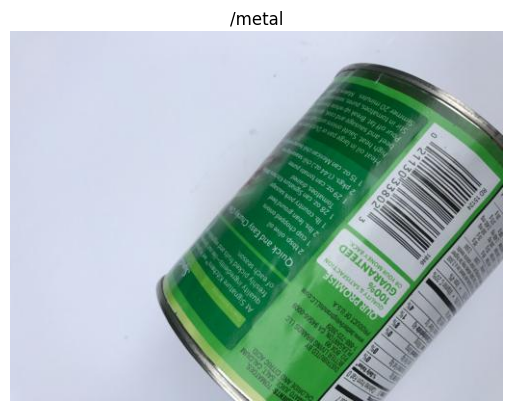

In [ ]:
img = view_random_image ('train_data', '/metal')

In [ ]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
base_model.trainable = False

In [ ]:
model = models.Sequential()
model.add(base_model)
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(1024, activation='relu', kernel_regularizer=l2(0.001)))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(8, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 5, 5, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 1024)              1311744   
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 batch_normalization (Batch  (None, 512)               2

In [ ]:
from tensorflow.keras.optimizers import RMSprop
model.compile(optimizer=RMSprop(learning_rate=0.0005),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

lr_reduction = ReduceLROnPlateau(monitor='val_loss', patience=2, verbose=1, factor=0.5, min_lr=0.00001)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True)

In [ ]:
# Train the model
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=val_generator,
    callbacks=[lr_reduction, early_stopping, model_checkpoint],
    steps_per_epoch=100,
    validation_steps=100
)

Epoch 1/50
100/100 [==============================] - ETA: 0s - loss: 2.0367 - accuracy: 0.6750

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


100/100 [==============================] - 176s 2s/step - loss: 2.0367 - accuracy: 0.6750 - val_loss: 1.7816 - val_accuracy: 0.7472 - lr: 5.0000e-04
Epoch 2/50
100/100 [==============================] - 165s 2s/step - loss: 1.7348 - accuracy: 0.7257 - val_loss: 1.5611 - val_accuracy: 0.7841 - lr: 5.0000e-04
Epoch 3/50
100/100 [==============================] - 171s 2s/step - loss: 1.5939 - accuracy: 0.7484 - val_loss: 1.5538 - val_accuracy: 0.7506 - lr: 5.0000e-04
Epoch 4/50
100/100 [==============================] - 144s 1s/step - loss: 1.4173 - accuracy: 0.7697 - val_loss: 1.2368 - val_accuracy: 0.8184 - lr: 5.0000e-04
Epoch 5/50
100/100 [==============================] - 167s 2s/step - loss: 1.3122 - accuracy: 0.7725 - val_loss: 1.1855 - val_accuracy: 0.8203 - lr: 5.0000e-04
Epoch 6/50
100/100 [==============================] - 159s 2s/step - loss: 1.1611 - accuracy: 0.7998 - val_loss: 1.2450 - val_accuracy: 0.7769 - lr: 5.0000e-04
Epoch 7/50
100/100 [==============================]

In [ ]:
val_loss, val_accuracy = model.evaluate(val_generator)
print(f'Validation Loss: {val_loss}')
print(f'Validation Accuracy: {val_accuracy}')

102/102 [==============================] - 82s 803ms/step - loss: 0.4083 - accuracy: 0.9152
Validation Loss: 0.4083295464515686
Validation Accuracy: 0.9151813387870789


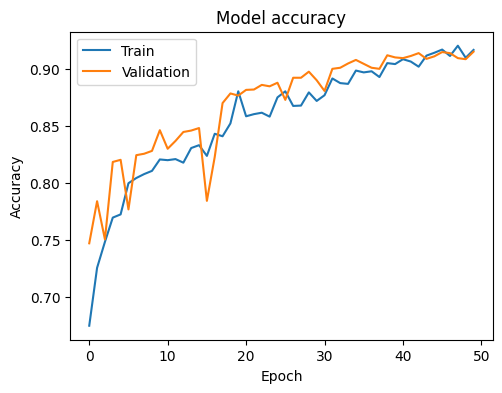

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

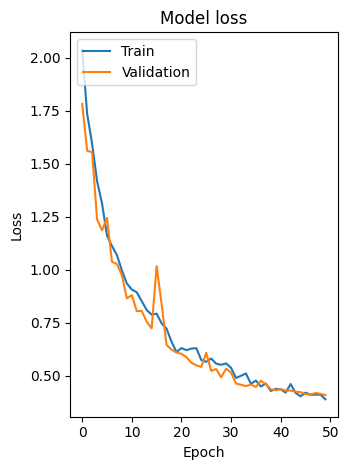

In [ ]:
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
from google.colab import files
from tensorflow.keras.utils import load_img, img_to_array

# Upload files
uploaded = files.upload()

for fn in uploaded.keys():
    path = fn
    img = load_img(path, target_size=(150, 150))

    # Convert the image to an array
    x = img_to_array(img)

    # Rescale the image
    x = x / 255.0

    # Expand the dimensions to match the input shape of the model
    x = np.expand_dims(x, axis=0)

    images = np.vstack([x])
    arr = model.predict(images, batch_size=10)

    # Get the index of the class with the highest probability
    predicted_class_index = np.argmax(arr)

    # Get the highest probability value
    predicted_probability = np.max(arr)

    # List of class labels
    class_labels = [
        'battery','biological', 'cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash'
    ]

    # Determine the label
    predicted_label = class_labels[predicted_class_index]

    # Print the result with the probability of the predicted class
    print('{} is a {} with a probability of {:.2f}%'.format(fn, predicted_label, predicted_probability * 100))

    # Print the probabilities for all classes
    for i, prob in enumerate(arr[0]):
        print('Probability of {}: {:.2f}%'.format(class_labels[i], prob * 100))



Saving metal can.jpg to metal can (1).jpg
1/1 [==============================] - 0s 47ms/step
metal can (1).jpg is a metal with a probability of 91.54%
Probability of battery: 3.65%
Probability of biological: 0.02%
Probability of cardboard: 2.70%
Probability of glass: 0.99%
Probability of metal: 91.54%
Probability of paper: 1.02%
Probability of plastic: 0.03%
Probability of trash: 0.04%


In [ ]:
model.save('wasteclassifierv3.h5')

NameError: name 'model' is not defined

In [ ]:
from google.colab import files

files.download('wasteclassifierv3.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>